# Investigating non-linear relationships in `Auto` dataset

## Preparing the data

### Import

In [253]:
# standard imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

auto = pd.read_csv('../../datasets/Auto.csv', index_col=0)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
1,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
3,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
4,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
5,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [26]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 1 to 397
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null int64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(3), int64(5), object(1)
memory usage: 30.6+ KB


### Encode categorical variables

The only categorical (non-ordinal) variable is `origin`

In [27]:
# numerical df with one hot encoding for origin variable
auto_num = pd.get_dummies(auto, columns=['origin'])
auto_num.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,name,origin_1,origin_2,origin_3
1,18.0,8,307.0,130,3504,12.0,70,chevrolet chevelle malibu,1,0,0
2,15.0,8,350.0,165,3693,11.5,70,buick skylark 320,1,0,0
3,18.0,8,318.0,150,3436,11.0,70,plymouth satellite,1,0,0
4,16.0,8,304.0,150,3433,12.0,70,amc rebel sst,1,0,0
5,17.0,8,302.0,140,3449,10.5,70,ford torino,1,0,0


## Inspecting the Data

Before training models we'll do some inspection to see if non-linear relationships are suggested by the data.

A pairplot produces all possible scatterplots of the variables

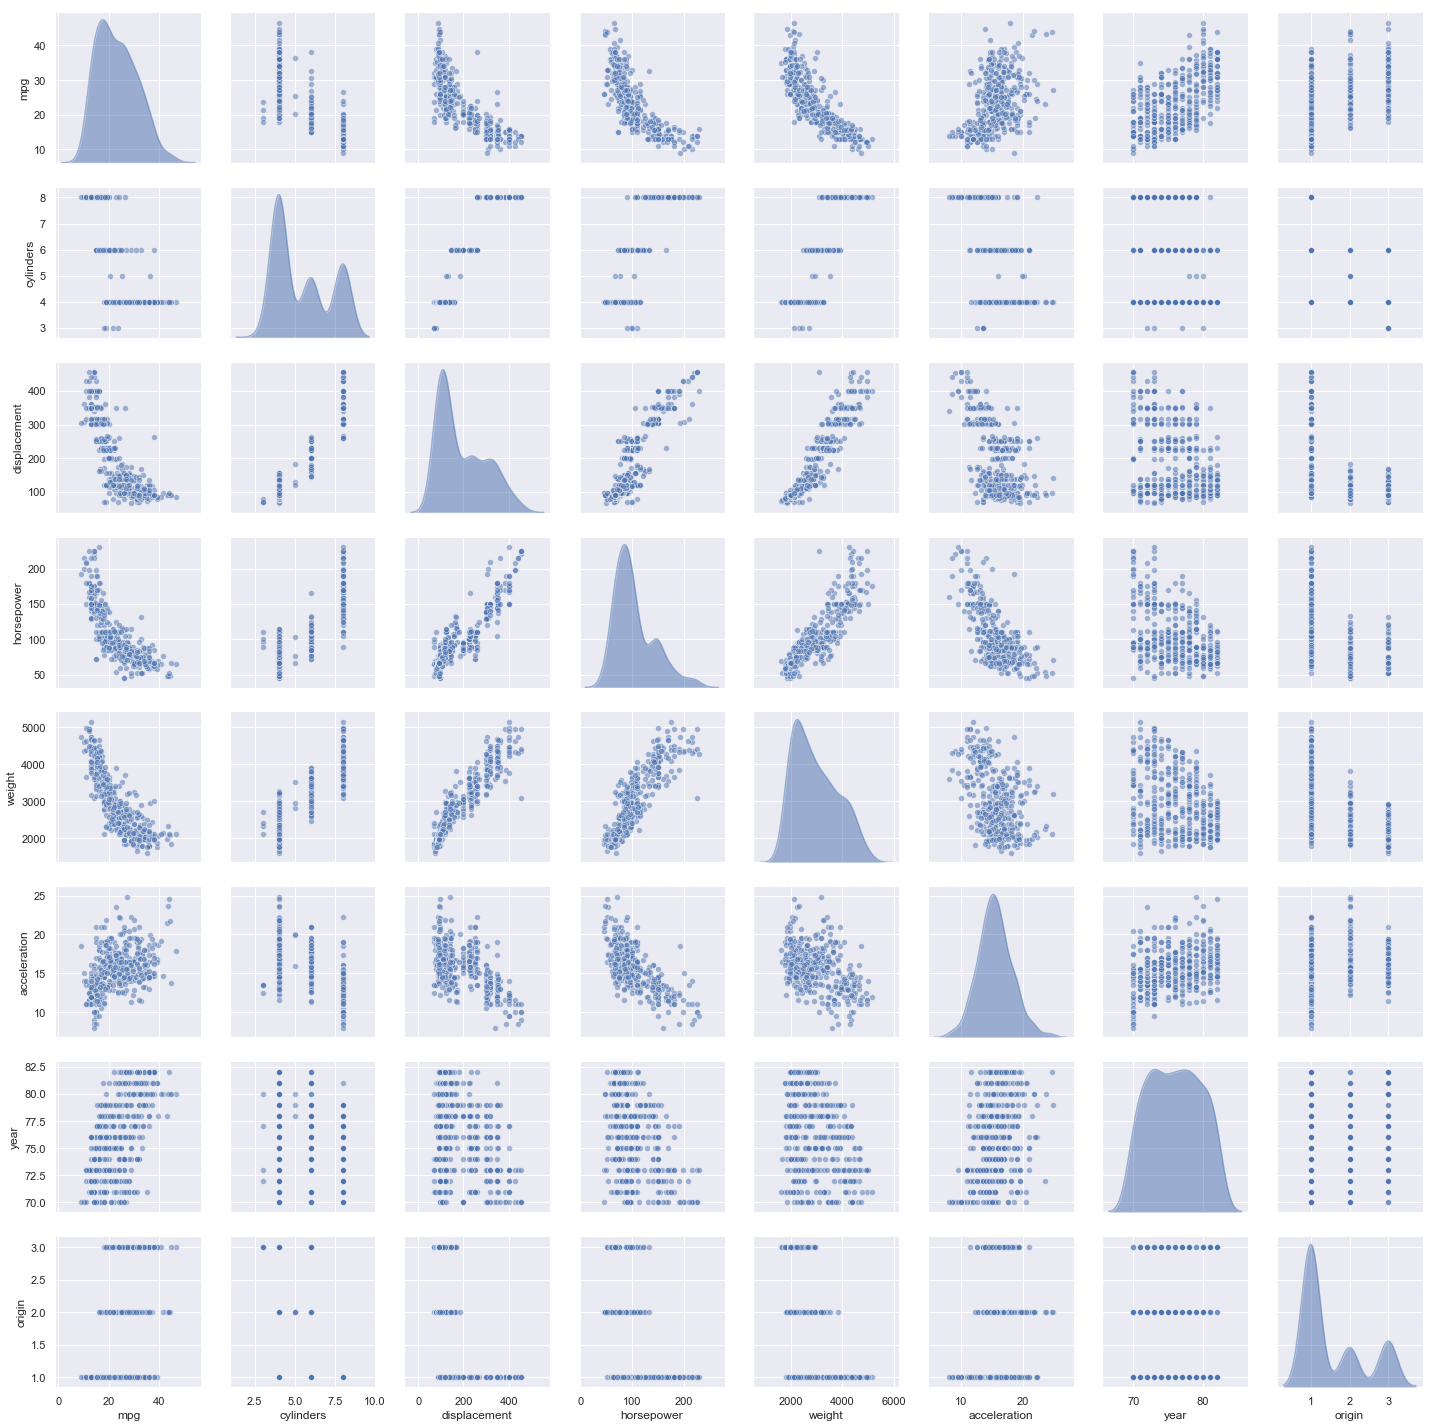

In [261]:
# pair plot to inspect distributions and scatterplots
sns.pairplot(data=auto, diag_kind='kde', plot_kws={'alpha':0.5},
             diag_kws={'alpha':0.5})

Observations:

- The plots strongly suggest that variables `weight`, `horsepower` and `displacement` have non-linear relationships to `mpg`
- The plots weakly suggest that `displacement` and `horsepower` may have a non-linear relationships to `acceleration`
- There is strong suggestion of some linear relationships as well.
- It's difficult to identify a non-linear relationship between two variables when one of them is discrete (e.g. `cylinders`, `year`)

## Modeling some non-linear relationships with `mpg`

Based on the pairplot we'll investigate non-linear relationships between  `acceleration`, `weight`, `horsepower`, and `displacement` with `mpg`. We'll try a few different types of models, using cross-validation to optimize, and then compare

In [180]:
cols = ['acceleration', 'weight', 'horsepower', 'displacement', 'mpg']
df = auto[cols]

# normalize
df = (df - df.mean())/df.std()

# series
acc, wt, hp, dp, mpg = df.acceleration.values, df.weight.values, df.horsepower.values, df.displacement.values, df.mpg.values

### Local Regression

In [357]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

lr_param_grid = {'n_neighbors': np.arange(1,7), 'weights': ['uniform', 'distance'], 
                     'p': np.arange(1, 7)}
lr_searches = [GridSearchCV(KNeighborsRegressor(), lr_param_grid, cv=5, 
                         scoring='neg_mean_squared_error') for i in range(4)]

In [358]:
%%capture
var_pairs = {'acc_mpg', 'wt_mpg', 'hp_mpg', 'dp_mpg'}
models = {name:None for name in ['local', 'poly', 'p-spline']}

models['local'] = {pair:None for pair in var_pairs}
models['local']['acc_mpg'] = lr_searches[0].fit(acc.reshape(-1, 1), mpg)
models['local']['wt_mpg'] = lr_searches[1].fit(wt.reshape(-1, 1), mpg)
models['local']['hp_mpg'] = lr_searches[2].fit(hp.reshape(-1, 1), mpg)
models['local']['dp_mpg'] = lr_searches[3].fit(dp.reshape(-1, 1), mpg)

### Polynomial Regression

In [359]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
reg_tree_search.best_params_

# 6-fold cv estimate of test rmse
np.sqrt(-reg_tree_search.best_score_)

from sklearn.metrics import mean_squared_error

# test set mse
final_reg_tree = reg_tree_search.best_estimator_
reg_tree_test_mse = mean_squared_error(final_reg_tree.predict(X_test), y_test)
np.sqrt(reg_tree_test_mse)
pr_pipe = Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge())])
pr_pipe_param_grid = {'poly__degree': np.arange(1, 5), 'ridge__alpha': np.logspace(-4, 4, 5)}
pr_searches = [GridSearchCV(estimator=pr_pipe, param_grid=pr_pipe_param_grid, cv=5, 
                              scoring='neg_mean_squared_error') for i in range(4)]

In [360]:
%%capture
models['poly'] = {pair:None for pair in var_pairs}
models['poly']['acc_mpg'] = pr_searches[0].fit(acc.reshape(-1, 1), mpg)
models['poly']['wt_mpg'] = pr_searches[1].fit(wt.reshape(-1, 1), mpg)
models['poly']['hp_mpg'] = pr_searches[2].fit(hp.reshape(-1, 1), mpg)
models['poly']['dp_mpg'] = pr_searches[3].fit(dp.reshape(-1, 1), mpg)

### Cubic P-Spline Regression

Thankfully `pygam`'s `GAM` plays nice with `sklearn`'s `GridSearchCV`.

In [381]:
from pygam import GAM, s

gam = GAM(s(0))

ps_param_grid = {'n_splines': np.arange(10, 16), 'spline_order': np.arange(2, 4), 
                 'lam': np.exp(np.random.rand(100, 1) * 6 - 3).flatten()}
ps_searches = [GridSearchCV(estimator=GAM(), param_grid=ps_param_grid, cv=5, scoring='neg_mean_squared_error')
               for i in range(4)]

Note that `pygam.GAM.gridsearch` uses generalized cross-validation (GCV).

In [385]:
%%capture
models['p-spline'] = {pair:None for pair in var_pairs}
models['p-spline']['acc_mpg'] = ps_searches[0].fit(acc.reshape(-1, 1), mpg)
models['p-spline']['wt_mpg'] = ps_searches[1].fit(wt.reshape(-1, 1), mpg)
models['p-spline']['hp_mpg'] = ps_searches[2].fit(hp.reshape(-1, 1), mpg)
models['p-spline']['dp_mpg'] = ps_searches[3].fit(dp.reshape(-1, 1), mpg)

### Model Comparison

### Optimal models and their test errors

In [386]:
cols = pd.MultiIndex.from_product([['acc_mpg', 'wt_mpg', 'hp_mpg', 'dp_mpg'], ['params', 'cv_mse']], 
                                  names=['var_pair', 'opt_results'])
rows = pd.Index(['local', 'poly', 'p-spline'], name='model_type')
    
models_df = pd.DataFrame(index=rows, columns=cols)
models_df

var_pair    acc_mpg        wt_mpg        hp_mpg        dp_mpg       
opt_results  params cv_mse params cv_mse params cv_mse params cv_mse
model_type                                                          
local           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
poly            NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN
p-spline        NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

In [387]:
for var_pair in models_df.columns.levels[0]:
    for name in models_df.index:
        models_df.loc[name, var_pair] = models[name][var_pair].best_params_, -models[name][var_pair].best_score_
        
models_df

var_pair                                               acc_mpg            \
opt_results                                             params    cv_mse   
model_type                                                                 
local         {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}   1.02543   
poly               {'poly__degree': 4, 'ridge__alpha': 0.0001}  0.969238   
p-spline     {'lam': 3.1804238375997853, 'n_splines': 10, '...  0.970488   

var_pair                                                wt_mpg            \
opt_results                                             params    cv_mse   
model_type                                                                 
local         {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}  0.421562   
poly               {'poly__degree': 2, 'ridge__alpha': 0.0001}  0.384849   
p-spline     {'lam': 3.1804238375997853, 'n_splines': 10, '...  0.391603   

var_pair                                                hp_mpg            \
opt_results                                             params    cv_mse   
model_type                                                                 
local        {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}  0.371018   
poly               {'poly__degree': 2, 'ridge__alpha': 0.0001}  0.399221   
p-spline     {'lam': 3.1804238375997853, 'n_splines': 10, '...  0.376321   

var_pair                                                dp_mpg            
opt_results                                             params    cv_mse  
model_type                                                                
local         {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}  0.406882  
poly               {'poly__degree': 2, 'ridge__alpha': 0.0001}  0.403257  
p-spline     {'lam': 3.1804238375997853, 'n_splines': 10, '...  0.392898

### Analysis of optimal models

In [388]:
# helper for plotting results

def plot_results(var_name, var):
    fig, axes = plt.subplots(nrows=3, figsize=(10,10))

    for i, model_type in enumerate(models):
        model = models[model_type][var_name + '_mpg']
        plt.subplot(3, 1, i + 1)
        sns.lineplot(x=var, y=model.predict(var.reshape(-1, 1)), color='red', 
                     label=model_type + " regression prediction")
        sns.scatterplot(x=var, y=mpg)
        plt.xlabel('std ' + var_name)
        plt.ylabel('std mpg')
        plt.legend()
        plt.tight_layout()

### `mpg` vs `accleration` 

The models seem to have much harder time predicting `mpg` from `acceleration`.

In [395]:
# mse estimates for acceleration models
models_df['acc_mpg']

opt_results,params,cv_mse
model_type,,
local,"{'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}",1.02543
poly,"{'poly__degree': 4, 'ridge__alpha': 0.0001}",0.969238
p-spline,"{'lam': 3.1804238375997853, 'n_splines': 10, '...",0.970488


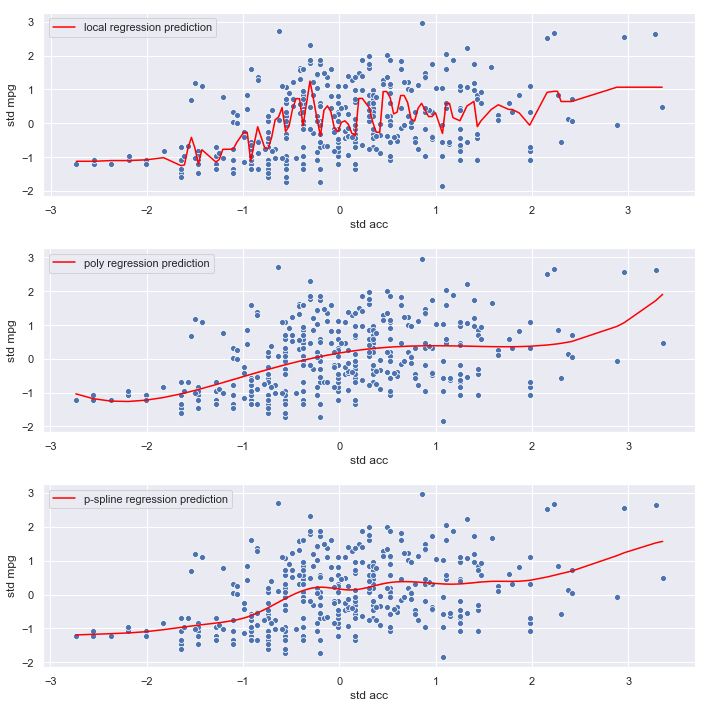

In [396]:
plot_results('acc', acc)

Observations:

- The local regression model seems to be fitting noise 
- The polynomial and p-spline models are smoother, and less likely to overfit, which is consistent with their lower mse estimates
- The relationship between `acceleration` and `mpg` appears weak

Conclusion:

There is little evidence of a relationship (linear or otherwise) between `acceleration` and `mpg` so we'll omit `acceleration` from the final model

### `mpg` vs. `weight`

In [397]:
# # mse estimates for acceleration models
models_df['wt_mpg']

opt_results,params,cv_mse
model_type,,
local,"{'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}",0.421562
poly,"{'poly__degree': 2, 'ridge__alpha': 0.0001}",0.384849
p-spline,"{'lam': 3.1804238375997853, 'n_splines': 10, '...",0.391603


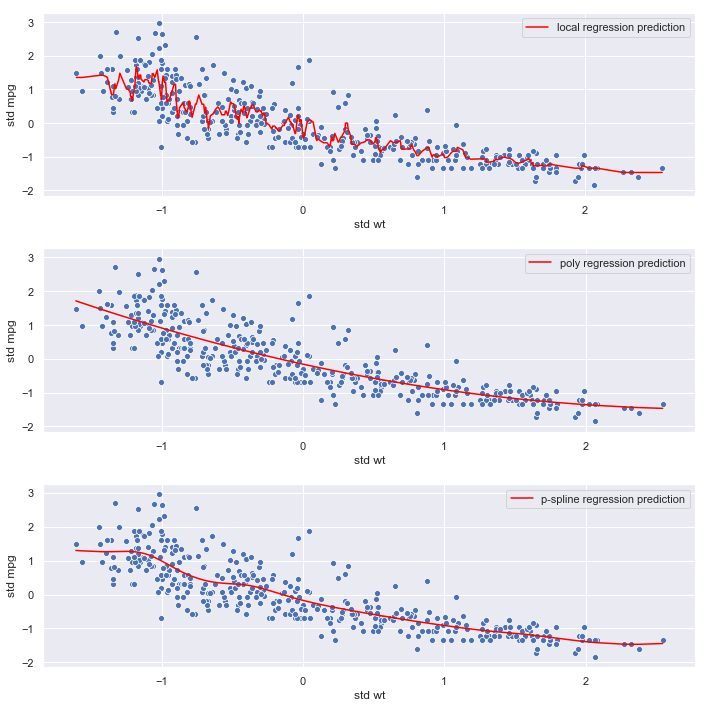

In [398]:
plot_results('wt', wt)

Observations:

- The local regression model again seems to be fitting noise 
- The polynomial and p-spline models are smoother, and less likely to overfit, which is consistent with their lower mse estimates
- The relationship between `weight` and `mpg` appears strong. 
- The p-spline and polynomial regression mses are very similar

In [399]:
models_df[('wt_mpg', 'params')]['poly']

{'poly__degree': 2, 'ridge__alpha': 0.0001}

In [400]:
models_df[('wt_mpg', 'params')]['p-spline']

{'lam': 3.1804238375997853, 'n_splines': 10, 'spline_order': 2}

Conclusion:

Optimal polynomial and p-spline models are both degree 2. Given its flexibility at the lower end of the range of `weight`, we'll select the p-spline for the final model.

### `mpg` vs. `horsepower`

In [401]:
# # mse estimates for acceleration models
models_df['hp_mpg']

opt_results,params,cv_mse
model_type,,
local,"{'n_neighbors': 4, 'p': 1, 'weights': 'distance'}",0.371018
poly,"{'poly__degree': 2, 'ridge__alpha': 0.0001}",0.399221
p-spline,"{'lam': 3.1804238375997853, 'n_splines': 10, '...",0.376321


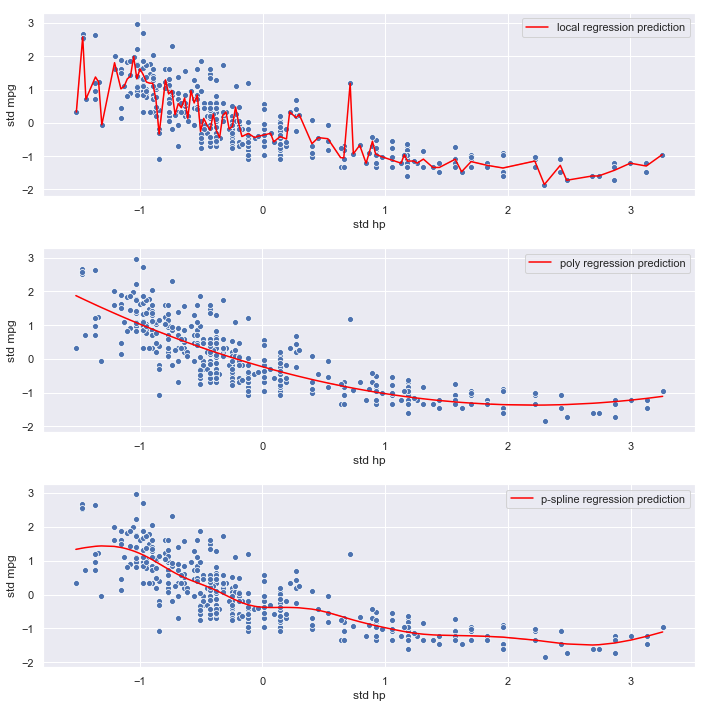

In [402]:
plot_results('hp', hp)

Observations:

- The local regression model again seems to be fitting noise 
- The polynomial and p-spline models are smoother, and less likely to overfit, which is consistent with their lower mse estimates
- The relationship between `horsepower` and `mpg` appears strong. 
- The p-spline and polynomial regression mses are very similar

In [403]:
models_df[('hp_mpg', 'params')]['poly']

{'poly__degree': 2, 'ridge__alpha': 0.0001}

In [404]:
models_df[('hp_mpg', 'params')]['p-spline']

{'lam': 3.1804238375997853, 'n_splines': 10, 'spline_order': 2}

Conclusion:

Optimal polynomial and p-spline models are both degree 2. Given its flexibility at the lower end of the range of `weight`, we'll select the p-spline for the final model.

### `mpg` vs. `displacement`

In [406]:
# # mse estimates for acceleration models
models_df['dp_mpg']

opt_results,params,cv_mse
model_type,,
local,"{'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}",0.406882
poly,"{'poly__degree': 2, 'ridge__alpha': 0.0001}",0.403257
p-spline,"{'lam': 3.1804238375997853, 'n_splines': 10, '...",0.392898


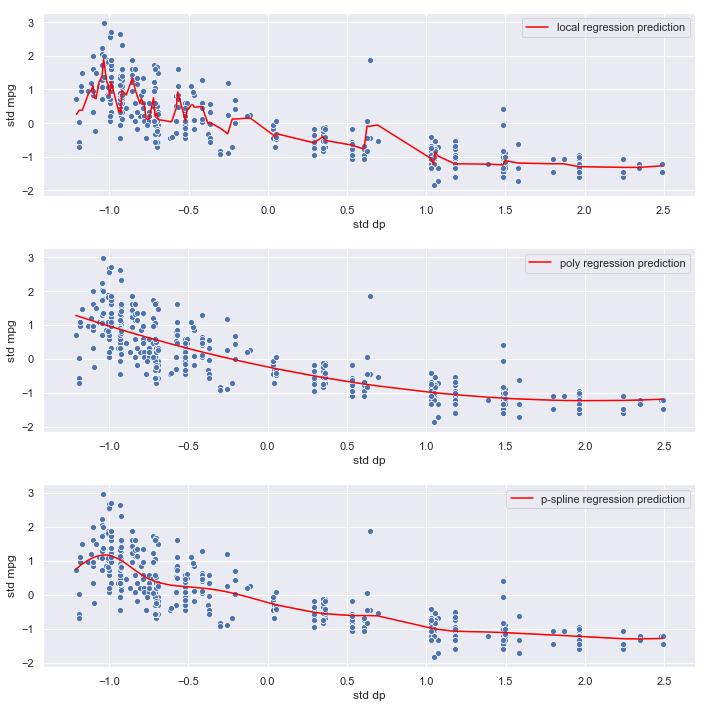

In [407]:
plot_results('dp', dp)

Observations:

- The local regression model again seems to be fitting noise 
- The polynomial and p-spline models are smoother, and less likely to overfit, which is consistent with their lower mse estimates
- The relationship between `displacement` and `mpg` appears strong. 
- The p-spline and polynomial regression mses are very similar

In [408]:
models_df[('dp_mpg', 'params')]['poly']

{'poly__degree': 2, 'ridge__alpha': 0.0001}

In [409]:
models_df[('dp_mpg', 'params')]['p-spline']

{'lam': 3.1804238375997853, 'n_splines': 10, 'spline_order': 2}

Conclusion:

Optimal polynomial and p-spline models are both degree 2. Given its flexibility at the lower end of the range of `weight`, we'll select the p-spline for the final model.

## GAM for predicting `mpg`

We identified some variables with non-linear relationships to `mpg` above, now we search for linear relationships. We'll then fit a GAM which is a kind of hybrid model - linear on the linear variables, non-linear on the non-linear variables.

$$Y = \beta_0 + \sum_{\text{linear}} \beta_j X_j + \sum_{\text{nonlinear}} \beta_k f_k(X_k)$$

where the nonlinear functions $f_k$ are those found above.

### Find variables with linear relationships to `mpg`

In [379]:
auto.corr()[auto.corr() > 0.5]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000000,NaN,NaN,NaN,NaN,NaN,0.580541,0.565209
cylinders,NaN,1.000000,0.950823,0.842983,0.897527,NaN,NaN,NaN
displacement,NaN,0.950823,1.000000,0.897257,0.932994,NaN,NaN,NaN
horsepower,NaN,0.842983,0.897257,1.000000,0.864538,NaN,NaN,NaN
weight,NaN,0.897527,0.932994,0.864538,1.000000,NaN,NaN,NaN
acceleration,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
year,0.580541,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
origin,0.565209,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


### Train GAM

In [410]:
gam_df = auto_num.copy()

gam_df = gam_df.drop(columns=['acceleration', 'name'])
num_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'year']
gam_df.loc[: , num_cols] = (gam_df[num_cols] - gam_df[num_cols].mean()) / gam_df[num_cols].std()

gam_df.head()

,mpg,cylinders,displacement,horsepower,weight,year,origin_1,origin_2,origin_3
1,-0.697747,1.482053,1.075915,0.663285,0.619748,-1.623241,1,0,0
2,-1.082115,1.482053,1.486832,1.572585,0.842258,-1.623241,1,0,0
3,-0.697747,1.482053,1.181033,1.182885,0.539692,-1.623241,1,0,0
4,-0.953992,1.482053,1.047246,1.182885,0.536160,-1.623241,1,0,0
5,-0.825870,1.482053,1.028134,0.923085,0.554997,-1.623241,1,0,0


In [411]:
from pygam import f

final_gam = GAM(s(1) + s(2) + s(3) + s(4) + s(5) + f(6) + f(7) + f(8))

ps_param_grid = {'n_splines': np.arange(15, 20), 'spline_order': np.arange(2, 3), 
                 'lam': np.exp(np.random.rand(100, 1) * 6 - 3).flatten()}
ps_search = GridSearchCV(estimator=GAM(), param_grid=ps_param_grid, cv=10, scoring='neg_mean_squared_error')
ps_search.fit(gam_df.drop(columns=['mpg']), gam_df['mpg'])

/Users/home/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GAM(callbacks=['deviance', 'diffs'], distribution='normal',
   fit_intercept=True, link='identity', max_iter=100, terms='auto',
   tol=0.0001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_splines': array([15, 16, 17, 18, 19]), 'spline_order': array([2]), 'lam': array([1.22679, 1.71212, ..., 0.19191, 0.68306])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

### Compare to alternative regression models

We'll compare our GAM to to alternative null, ordinary least squares and polynomial ridge regression models.

In [427]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score

X, y = gam_df.drop(columns=['mpg']), gam_df['mpg']

# dummy model that always predicts mean response
dummy = DummyRegressor().fit(X, y)
dummy_cv_mse = np.mean(-cross_val_score(dummy, X, y, scoring='neg_mean_squared_error', cv=10))

# ordinary least squares
ols = LinearRegression().fit(X, y)
ols_cv_mse = np.mean(-cross_val_score(ols, X, y, scoring='neg_mean_squared_error', cv=10))

# optimized polynomial ridge
pr_pipe = Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge())])
pr_pipe_param_grid = {'poly__degree': np.arange(1, 5), 'ridge__alpha': np.logspace(-4, 4, 5)}
pr_search = GridSearchCV(estimator=pr_pipe, param_grid=pr_pipe_param_grid, cv=10, 
                              scoring='neg_mean_squared_error')
ridge = pr_search.fit(X, y)
ridge_cv_mse = -ridge.best_score_

gam_cv_mse = -ps_search.best_score_

/Users/home/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [428]:
comparison_df = pd.DataFrame({'cv_mse': [dummy_cv_mse, ols_cv_mse, ridge_cv_mse, gam_cv_mse]}, 
                             index=['dummy', 'ols', 'poly ridge', 'gam'])
comparison_df

,cv_mse
dummy,1.092509
ols,0.203995
poly ridge,0.127831
gam,0.201342


The polynomial ridge model has outperformed

In [429]:
ridge.best_params_

{'poly__degree': 3, 'ridge__alpha': 1.0}